In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme()

In [32]:
json_dir = 'intervals/'

data = []

for filename in os.listdir(json_dir):
    if filename.endswith('.json'):

        filepath = os.path.join(json_dir, filename)
        series = pd.read_json(filepath, orient='records', typ='series')

        data.append(series)

df = pd.DataFrame(data)
df['level'] = df['level'].round(2)


In [33]:
json_dir_qrf = 'qrf_intervals/'

data_qrf = []

for filename in os.listdir(json_dir_qrf):
    if filename.endswith('.json'):

        filepath = os.path.join(json_dir_qrf, filename)
        series = pd.read_json(filepath, orient='records', typ='series')

        data_qrf.append(series)

df_qrf = pd.DataFrame(data_qrf)
df_qrf['level'] = df_qrf['level'].round(2)

In [36]:
df_combined = pd.concat([df, df_qrf], axis=0)

In [40]:
df_level_neighs = df_combined.groupby(['level', 'n_neighbors'])[['width_mean']].agg([np.mean, np.std]).reset_index()

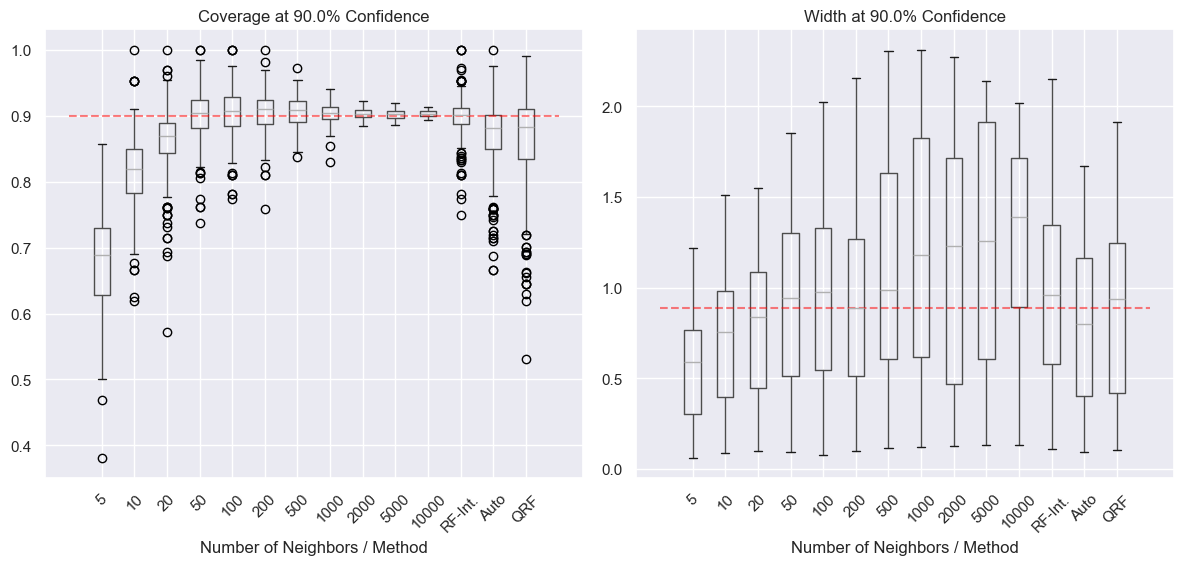

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
level = 0.90
df_level = df_combined[df_combined['level'] == level]

xtick_labels = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 'RF-Int.', 'Auto', 'QRF']

df_level.boxplot(column='coverage', by=['n_neighbors'], ax = ax[0])
ax[0].hlines(level, 0, 15, color = 'red', alpha = 0.5, linestyle = '--')
ax[0].set_title(f'Coverage at {level * 100}% Confidence')
ax[0].set_xticklabels(xtick_labels, rotation = 45)
ax[0].set_xlabel('Number of Neighbors / Method')

df_level.boxplot(column='width_mean', by=['n_neighbors'], ax = ax[1])
ax[1].hlines(df_level.width_mean.mean(), 0, 15, color = 'red', alpha = 0.5, linestyle = '--')
ax[1].set_title(f'Width at {level * 100}% Confidence')
ax[1].set_xticklabels(xtick_labels, rotation = 45)
ax[1].set_xlabel('Number of Neighbors / Method')

fig.suptitle('')
plt.tight_layout()
# plt.savefig('coverage_width.pdf')



<Axes: xlabel='data_name', ylabel='width_q1'>

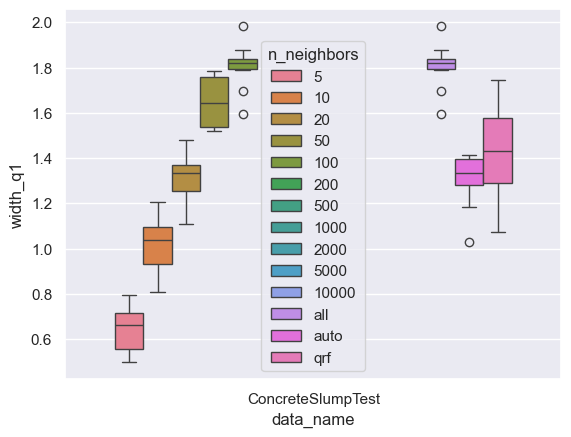

In [44]:
subset_df = df_combined[(df_combined['level'] == 0.95) & (df_combined['data_name'] == 'ConcreteSlumpTest')]
hue_order = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 'all', 'auto', 'qrf']


sns.boxplot(subset_df, x = 'data_name', y = 'width_q1', hue='n_neighbors',
            hue_order = hue_order)